# GSoC 2025 - ML4Sci EXXA Test
## Part 2: Autoencoder for Protoplanetary Disks

**Candidate:** Gargi Tripathi
**Date:** 12/10/2025

### Objective
Train an autoencoder to reconstruct protoplanetary disk images with an accessible latent space.

### Approach
1. Load and preprocess FITS files
2. Build convolutional autoencoder
3. Train with MSE + MS-SSIM loss
4. Evaluate reconstruction quality
5. Demonstrate latent space access

In [8]:
# Installing required packages
!pip install astropy torch torchvision matplotlib seaborn pandas numpy tqdm pytorch-msssim

print("All packages installed successfully")

All packages installed successfully


In [9]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader, random_split
import astropy.io.fits as fits
import pandas as pd
import os
from tqdm import tqdm
import warnings
from pytorch_msssim import ms_ssim
import time

warnings.filterwarnings('ignore')

# Setting random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

print("Libraries imported successfully")

Libraries imported successfully


In [10]:
# @title Download Data
print("DOWNLOADING DATA FOR PART 2...")

import gdown
import zipfile
import os

# Create data directory
!mkdir -p /content/data

# Download from the same Google Drive link
file_id = "1VkS3RHkAjiKjJ6DnZmEKZ_nUv4w6pz7P"
url = f"https://drive.google.com/uc?id={file_id}"
output = "protoplanetary_disks.zip"

print("Downloading data...")
try:
    gdown.download(url, output, quiet=False)

    print("Extracting data...")
    with zipfile.ZipFile(output, 'r') as zip_ref:
        zip_ref.extractall("/content/data")

    print("Data downloaded and extracted successfully!")

except Exception as e:
    print(f"Download failed: {e}")
    print("Trying alternative method...")

    # Alternative: Manual upload
    from google.colab import files
    print("Please upload the ZIP file manually:")
    uploaded = files.upload()

    for filename in uploaded.keys():
        if filename.endswith('.zip'):
            print(f"Extracting {filename}...")
            with zipfile.ZipFile(filename, 'r') as zip_ref:
                zip_ref.extractall("/content/data")
            break

# Verify data
print("\nData directory contents:")
!find "/content/data" -name "*.fits" | head -5
print("...")

data_dir = "/content/data"
print(f"Data ready at: {data_dir}")

DOWNLOADING DATA FOR PART 2...
Download failed: Failed to retrieve file url:

	Cannot retrieve the public link of the file. You may need to change
	the permission to 'Anyone with the link', or have had many accesses.
	Check FAQ in https://github.com/wkentaro/gdown?tab=readme-ov-file#faq.

You may still be able to access the file from the browser:

	https://drive.google.com/uc?id=1VkS3RHkAjiKjJ6DnZmEKZ_nUv4w6pz7P

but Gdown can't. Please check connections and permissions.
Trying alternative method...
Please upload the ZIP file manually:


Saving continuum_data_subset-20251111T160904Z-1-001.zip to continuum_data_subset-20251111T160904Z-1-001.zip
Extracting continuum_data_subset-20251111T160904Z-1-001.zip...

Data directory contents:
/content/data/continuum_data_subset/planet9_00440_1250.fits
/content/data/continuum_data_subset/planet6_00704_1250.fits
/content/data/continuum_data_subset/planet38_00948_1250.fits
/content/data/continuum_data_subset/planet102_00346_1250.fits
/content/data/continuum_data_subset/planet13_00324_1250.fits
...
Data ready at: /content/data


In [44]:
# @title Data Setup
data_dir = "/content/data"  # Update this path if needed
print(f"Data directory: {data_dir}")

# Listing available FITS files
fits_files = [f for f in os.listdir(data_dir) if f.endswith('.fits')]
print(f"Found {len(fits_files)} FITS files")

Data directory: /content/data
Found 0 FITS files


In [45]:
class ProtoplanetaryDiskDataset(Dataset):
    def __init__(self, data_dir, transform=None, img_size=224):
        self.data_dir = data_dir
        self.transform = transform
        self.img_size = img_size

        # Finding all FITS files
        self.file_list = []
        for root, dirs, files in os.walk(data_dir):
            for file in files:
                if file.endswith('.fits'):
                    self.file_list.append(os.path.join(root, file))

        print(f"Found {len(self.file_list)} FITS files in {data_dir}")

        if len(self.file_list) == 0:
            raise ValueError(f"No FITS files found in {data_dir}")

        # Basic transforms
        if self.transform is None:
            self.transform = transforms.Compose([
                transforms.ToTensor(),
                transforms.Resize((img_size, img_size)),
                transforms.Normalize(mean=[0.5], std=[0.5])
            ])

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        file_path = self.file_list[idx]

        try:
            # Reading FITS file
            with fits.open(file_path) as hdul:
                data = hdul[0].data

                # Handling different data dimensions
                if data.shape == (4, 1, 1, 600, 600):
                    image_data = data[0, 0, 0]  # Extract 2D image
                elif data.ndim == 4:
                    image_data = data[0]
                elif data.ndim == 3:
                    image_data = data[0]
                elif data.ndim == 2:
                    image_data = data
                else:
                    # For any other dimension, extracting 2D data
                    while data.ndim > 2:
                        data = data[0]
                    image_data = data

            # Handling NaN values and normalize
            image_data = np.nan_to_num(image_data, nan=0.0)

            # Normalize to [0, 1]
            if np.max(image_data) > np.min(image_data):
                image_data = (image_data - np.min(image_data)) / (np.max(image_data) - np.min(image_data))
            else:
                image_data = np.zeros_like(image_data)

            # Convert to PIL-like format for transforms
            image_data = (image_data * 255).astype(np.uint8)

            # Apply transforms
            if self.transform:
                # Convert to 3-channel for pre-trained models
                image_rgb = np.stack([image_data] * 3, axis=-1)
                tensor_image = self.transform(image_rgb)
            else:
                tensor_image = torch.tensor(image_data, dtype=torch.float32).unsqueeze(0)

            return tensor_image, os.path.basename(file_path)

        except Exception as e:
            print(f"Error loading {file_path}: {e}")
            # Return a blank image if there's an error
            blank_image = torch.zeros((3, self.img_size, self.img_size))
            return blank_image, "error"

# Creating dataset
dataset = ProtoplanetaryDiskDataset(data_dir)
print(f"Dataset created with {len(dataset)} images")

Found 150 FITS files in /content/data
Dataset created with 150 images


In [52]:
# @title DATA PREPROCESSING
print("DATA PREPROCESSING...")

class FixedProtoplanetaryDataset(Dataset):
    def __init__(self, data_dir, img_size=256):
        self.data_dir = data_dir
        self.img_size = img_size
        self.file_list = []

        for root, dirs, files in os.walk(data_dir):
            for file in files:
                if file.endswith('.fits'):
                    self.file_list.append(os.path.join(root, file))

        print(f"Found {len(self.file_list)} FITS files")

        #  transforms for planetary disks
        self.transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Resize((img_size, img_size)),
            transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
        ])

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        file_path = self.file_list[idx]

        try:
            with fits.open(file_path) as hdul:
                data = hdul[0].data

                if data.shape == (4, 1, 1, 600, 600):
                    image_data = data[0, 0, 0]
                elif data.ndim == 4:
                    image_data = data[0]
                elif data.ndim == 3:
                    image_data = data[0]
                elif data.ndim == 2:
                    image_data = data
                else:
                    while data.ndim > 2:
                        data = data[0]
                    image_data = data

            #  normalization
            image_data = np.nan_to_num(image_data, nan=0.0)

            # Enhanced normalization
            if np.max(image_data) > np.min(image_data):
                # Stretch contrast for better features
                p_low, p_high = np.percentile(image_data, [5, 95])
                image_data = np.clip(image_data, p_low, p_high)
                image_data = (image_data - p_low) / (p_high - p_low)
            else:
                image_data = np.zeros_like(image_data)

            # Convert to uint8
            image_data = (image_data * 255).astype(np.uint8)

            # Apply transforms
            image_rgb = np.stack([image_data] * 3, axis=-1)
            tensor_image = self.transform(image_rgb)

            return tensor_image, os.path.basename(file_path)

        except Exception as e:
            print(f"Error loading {file_path}: {e}")
            blank_image = torch.zeros((3, self.img_size, self.img_size))
            return blank_image, "error"


dataset = FixedProtoplanetaryDataset(data_dir, img_size=256)
print(f"Fixed dataset with {len(dataset)} images (256x256)")


dataset_size = len(dataset)
train_size = int(0.8 * dataset_size)
val_size = dataset_size - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)  # Smaller batch for 256x256
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

print(f" New dataset: Train={train_size}, Val={val_size}, Size=256x256")

DATA PREPROCESSING...
Found 150 FITS files
Fixed dataset with 150 images (256x256)
 New dataset: Train=120, Val=30, Size=256x256


In [54]:
# @title  AUTOENCODER
print("BUILDING  AUTOENCODER")

class UltimatePlanetaryAutoencoder(nn.Module):
    def __init__(self, latent_dim=512):
        super(UltimatePlanetaryAutoencoder, self).__init__()

        # ENCODER
        self.encoder = nn.Sequential(

            nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),


            nn.Conv2d(64, 128, kernel_size=5, stride=2, padding=2),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),


            nn.Conv2d(128, 256, kernel_size=5, stride=2, padding=2),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),


            nn.Conv2d(256, 512, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),


            nn.Conv2d(512, 512, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),

            nn.AdaptiveAvgPool2d((4, 4)),
            nn.Flatten(),
            nn.Linear(512 * 4 * 4, latent_dim),
            nn.BatchNorm1d(latent_dim),
            nn.Tanh()
        )

        # DECODER
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 512 * 4 * 4),
            nn.Unflatten(1, (512, 4, 4)),


            nn.ConvTranspose2d(512, 512, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),


            nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),


            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),


            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),


            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),


            nn.ConvTranspose2d(32, 3, kernel_size=4, stride=2, padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        latent = self.encode(x)
        reconstructed = self.decode(latent)
        return reconstructed, latent

    def encode(self, x):
        return self.encoder(x)

    def decode(self, z):
        return self.decoder(z)

# Initialize  model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
autoencoder = UltimatePlanetaryAutoencoder(latent_dim=512).to(device)
print(f" Autoencoder Ready ")
print(f"Parameters: {sum(p.numel() for p in autoencoder.parameters()):,}")

BUILDING  AUTOENCODER
 Autoencoder Ready 
Parameters: 19,959,203


In [55]:
# @title TRAINING
print("STARTING TRAINING...")

import torch.optim as optim
from torch.optim.lr_scheduler import OneCycleLR

#  Optimizer
optimizer = optim.AdamW(
    autoencoder.parameters(),
    lr=1e-3,  # Higher initial LR for OneCycle
    weight_decay=1e-6,
    betas=(0.9, 0.999)
)

# OneCycle LR Scheduler
scheduler = OneCycleLR(
    optimizer,
    max_lr=1e-3,
    epochs=60,
    steps_per_epoch=len(train_loader),
    pct_start=0.3,
    div_factor=10,
    final_div_factor=100
)

# Custom ULTIMATE loss function
def ultimate_loss(reconstructed, original, epoch):
    # Base MSE
    mse_loss = F.mse_loss(reconstructed, original)

    # MS-SSIM for structural similarity
    ssim_loss = 1 - ms_ssim(reconstructed, original, data_range=1.0, size_average=True)

    # Perceptual loss (approximate)
    perceptual_loss = F.l1_loss(reconstructed, original)

    # Progressive weighting
    if epoch < 20:
        # Focus on basic reconstruction first
        return mse_loss + 0.1 * ssim_loss
    elif epoch < 40:
        # Add more structural focus
        return 0.7 * mse_loss + 0.3 * ssim_loss + 0.1 * perceptual_loss
    else:
        # Full loss for fine-tuning
        return 0.5 * mse_loss + 0.4 * ssim_loss + 0.1 * perceptual_loss

# Training
num_epochs = 60
best_loss = float('inf')
train_losses = []
val_losses = []

print("STARTING  TRAINING...")

for epoch in range(num_epochs):
    # === TRAINING ===
    autoencoder.train()
    epoch_train_loss = 0.0

    for batch_idx, (data, _) in enumerate(tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")):
        data = data.to(device)

        optimizer.zero_grad()
        reconstructed, latent = autoencoder(data)

        # Ultimate loss
        loss = ultimate_loss(reconstructed, data, epoch)

        loss.backward()

        # Gradient clipping
        torch.nn.utils.clip_grad_norm_(autoencoder.parameters(), 1.0)

        optimizer.step()
        scheduler.step()  # Step per batch for OneCycle

        epoch_train_loss += loss.item()

    avg_train_loss = epoch_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # === VALIDATION ===
    autoencoder.eval()
    epoch_val_loss = 0.0
    epoch_val_ssim = 0.0

    with torch.no_grad():
        for data, _ in val_loader:
            data = data.to(device)
            reconstructed, latent = autoencoder(data)

            val_loss = F.mse_loss(reconstructed, data)
            val_ssim = ms_ssim(reconstructed, data, data_range=1.0)

            epoch_val_loss += val_loss.item()
            epoch_val_ssim += val_ssim.item()

    avg_val_loss = epoch_val_loss / len(val_loader)
    avg_val_ssim = epoch_val_ssim / len(val_loader)
    val_losses.append(avg_val_loss)

    # === PROGRESS REPORTING ===
    current_lr = scheduler.get_last_lr()[0]
    print(f"Epoch {epoch+1}/{num_epochs}:")
    print(f"   Train: {avg_train_loss:.4f} | Val: {avg_val_loss:.4f} | SSIM: {avg_val_ssim:.4f}")
    print(f"   LR: {current_lr:.2e}")

    # Save BEST model
    if avg_val_loss < best_loss:
        best_loss = avg_val_loss
        torch.save({
            'epoch': epoch,
            'model_state_dict': autoencoder.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': best_loss,
        }, 'ULTIMATE_planetary_autoencoder.pth')
        print("   NEW BEST MODEL SAVED!")

    # Early stopping check
    if avg_val_loss < 0.05:  # Excellent performance
        print(" TARGET ACHIEVED  Stopping early")
        break

    if epoch > 20 and avg_val_loss > 1.0:  # Not learning
        print(" Poor convergence  adjusting strategy")
        # Could add more adjustments here

print("TRAINING COMPLETED!")

# Load the absolute best model
checkpoint = torch.load('ULTIMATE_planetary_autoencoder.pth')
autoencoder.load_state_dict(checkpoint['model_state_dict'])
print(f"Loaded best model (Loss: {checkpoint['loss']:.4f})")

STARTING TRAINING...
STARTING  TRAINING...


Epoch 1/60: 100%|██████████| 8/8 [01:07<00:00,  8.42s/it]


Epoch 1/60:
   Train: 1.5967 | Val: 1.5203 | SSIM: 0.0656
   LR: 1.07e-04
   NEW BEST MODEL SAVED!


Epoch 2/60: 100%|██████████| 8/8 [01:04<00:00,  8.12s/it]


Epoch 2/60:
   Train: 1.5368 | Val: 1.4576 | SSIM: 0.0657
   LR: 1.28e-04
   NEW BEST MODEL SAVED!


Epoch 3/60: 100%|██████████| 8/8 [01:01<00:00,  7.73s/it]


Epoch 3/60:
   Train: 1.4467 | Val: 1.3379 | SSIM: 0.1083
   LR: 1.61e-04
   NEW BEST MODEL SAVED!


Epoch 4/60: 100%|██████████| 8/8 [01:01<00:00,  7.64s/it]


Epoch 4/60:
   Train: 1.3825 | Val: 1.2407 | SSIM: 0.1933
   LR: 2.07e-04
   NEW BEST MODEL SAVED!


Epoch 5/60: 100%|██████████| 8/8 [01:03<00:00,  7.88s/it]


Epoch 5/60:
   Train: 1.3167 | Val: 1.2085 | SSIM: 0.2102
   LR: 2.63e-04
   NEW BEST MODEL SAVED!


Epoch 6/60: 100%|██████████| 8/8 [01:02<00:00,  7.79s/it]


Epoch 6/60:
   Train: 1.2657 | Val: 1.1189 | SSIM: 0.2344
   LR: 3.28e-04
   NEW BEST MODEL SAVED!


Epoch 7/60: 100%|██████████| 8/8 [01:04<00:00,  8.02s/it]


Epoch 7/60:
   Train: 1.2053 | Val: 1.0618 | SSIM: 0.2412
   LR: 4.00e-04
   NEW BEST MODEL SAVED!


Epoch 8/60: 100%|██████████| 8/8 [01:03<00:00,  7.89s/it]


Epoch 8/60:
   Train: 1.1464 | Val: 0.9600 | SSIM: 0.2637
   LR: 4.76e-04
   NEW BEST MODEL SAVED!


Epoch 9/60: 100%|██████████| 8/8 [01:03<00:00,  7.89s/it]


Epoch 9/60:
   Train: 1.0668 | Val: 0.9325 | SSIM: 0.2897
   LR: 5.55e-04
   NEW BEST MODEL SAVED!


Epoch 10/60: 100%|██████████| 8/8 [01:04<00:00,  8.03s/it]


Epoch 10/60:
   Train: 1.0043 | Val: 0.8698 | SSIM: 0.3137
   LR: 6.34e-04
   NEW BEST MODEL SAVED!


Epoch 11/60: 100%|██████████| 8/8 [01:03<00:00,  7.89s/it]


Epoch 11/60:
   Train: 0.9512 | Val: 0.8194 | SSIM: 0.3173
   LR: 7.10e-04
   NEW BEST MODEL SAVED!


Epoch 12/60: 100%|██████████| 8/8 [01:03<00:00,  7.96s/it]


Epoch 12/60:
   Train: 0.8922 | Val: 0.8106 | SSIM: 0.3509
   LR: 7.81e-04
   NEW BEST MODEL SAVED!


Epoch 13/60: 100%|██████████| 8/8 [01:04<00:00,  8.07s/it]


Epoch 13/60:
   Train: 0.8652 | Val: 0.7542 | SSIM: 0.3434
   LR: 8.45e-04
   NEW BEST MODEL SAVED!


Epoch 14/60: 100%|██████████| 8/8 [01:03<00:00,  7.88s/it]


Epoch 14/60:
   Train: 0.8380 | Val: 0.7504 | SSIM: 0.3179
   LR: 9.00e-04
   NEW BEST MODEL SAVED!


Epoch 15/60: 100%|██████████| 8/8 [01:02<00:00,  7.79s/it]


Epoch 15/60:
   Train: 0.8210 | Val: 0.7262 | SSIM: 0.3327
   LR: 9.44e-04
   NEW BEST MODEL SAVED!


Epoch 16/60: 100%|██████████| 8/8 [01:03<00:00,  7.94s/it]


Epoch 16/60:
   Train: 0.8055 | Val: 0.7243 | SSIM: 0.3742
   LR: 9.76e-04
   NEW BEST MODEL SAVED!


Epoch 17/60: 100%|██████████| 8/8 [01:03<00:00,  7.93s/it]


Epoch 17/60:
   Train: 0.7917 | Val: 0.7326 | SSIM: 0.2097
   LR: 9.95e-04


Epoch 18/60: 100%|██████████| 8/8 [01:03<00:00,  7.95s/it]


Epoch 18/60:
   Train: 0.7826 | Val: 0.7574 | SSIM: 0.3835
   LR: 1.00e-03


Epoch 19/60: 100%|██████████| 8/8 [01:03<00:00,  7.90s/it]


Epoch 19/60:
   Train: 0.7754 | Val: 0.7393 | SSIM: 0.3912
   LR: 9.98e-04


Epoch 20/60: 100%|██████████| 8/8 [01:03<00:00,  7.94s/it]


Epoch 20/60:
   Train: 0.7771 | Val: 0.7117 | SSIM: 0.3768
   LR: 9.94e-04
   NEW BEST MODEL SAVED!


Epoch 21/60: 100%|██████████| 8/8 [01:04<00:00,  8.04s/it]


Epoch 21/60:
   Train: 0.7432 | Val: 0.7007 | SSIM: 0.3978
   LR: 9.86e-04
   NEW BEST MODEL SAVED!


Epoch 22/60: 100%|██████████| 8/8 [01:03<00:00,  7.94s/it]


Epoch 22/60:
   Train: 0.7315 | Val: 0.7653 | SSIM: 0.3822
   LR: 9.76e-04


Epoch 23/60: 100%|██████████| 8/8 [01:04<00:00,  8.02s/it]


Epoch 23/60:
   Train: 0.7383 | Val: 0.7028 | SSIM: 0.3816
   LR: 9.64e-04


Epoch 24/60: 100%|██████████| 8/8 [01:03<00:00,  7.88s/it]


Epoch 24/60:
   Train: 0.7465 | Val: 0.9099 | SSIM: 0.3305
   LR: 9.48e-04


Epoch 25/60: 100%|██████████| 8/8 [01:02<00:00,  7.81s/it]


Epoch 25/60:
   Train: 0.7551 | Val: 1.1287 | SSIM: 0.2926
   LR: 9.31e-04
 Poor convergence  adjusting strategy


Epoch 26/60: 100%|██████████| 8/8 [01:01<00:00,  7.73s/it]


Epoch 26/60:
   Train: 0.7510 | Val: 0.8479 | SSIM: 0.3411
   LR: 9.11e-04


Epoch 27/60: 100%|██████████| 8/8 [01:02<00:00,  7.87s/it]


Epoch 27/60:
   Train: 0.7487 | Val: 0.7354 | SSIM: 0.3983
   LR: 8.88e-04


Epoch 28/60: 100%|██████████| 8/8 [01:02<00:00,  7.85s/it]


Epoch 28/60:
   Train: 0.7291 | Val: 0.6828 | SSIM: 0.3676
   LR: 8.63e-04
   NEW BEST MODEL SAVED!


Epoch 29/60: 100%|██████████| 8/8 [01:02<00:00,  7.83s/it]


Epoch 29/60:
   Train: 0.7346 | Val: 0.6817 | SSIM: 0.3988
   LR: 8.37e-04
   NEW BEST MODEL SAVED!


Epoch 30/60: 100%|██████████| 8/8 [01:02<00:00,  7.82s/it]


Epoch 30/60:
   Train: 0.7235 | Val: 0.6804 | SSIM: 0.3905
   LR: 8.08e-04
   NEW BEST MODEL SAVED!


Epoch 31/60: 100%|██████████| 8/8 [01:03<00:00,  7.89s/it]


Epoch 31/60:
   Train: 0.7256 | Val: 0.6766 | SSIM: 0.3970
   LR: 7.78e-04
   NEW BEST MODEL SAVED!


Epoch 32/60: 100%|██████████| 8/8 [01:01<00:00,  7.71s/it]


Epoch 32/60:
   Train: 0.7174 | Val: 0.6748 | SSIM: 0.3976
   LR: 7.46e-04
   NEW BEST MODEL SAVED!


Epoch 33/60: 100%|██████████| 8/8 [01:02<00:00,  7.87s/it]


Epoch 33/60:
   Train: 0.7196 | Val: 0.6767 | SSIM: 0.3921
   LR: 7.13e-04


Epoch 34/60: 100%|██████████| 8/8 [01:02<00:00,  7.77s/it]


Epoch 34/60:
   Train: 0.7179 | Val: 0.6766 | SSIM: 0.4084
   LR: 6.79e-04


Epoch 35/60: 100%|██████████| 8/8 [01:02<00:00,  7.87s/it]


Epoch 35/60:
   Train: 0.7181 | Val: 0.6736 | SSIM: 0.3940
   LR: 6.43e-04
   NEW BEST MODEL SAVED!


Epoch 36/60: 100%|██████████| 8/8 [01:04<00:00,  8.04s/it]


Epoch 36/60:
   Train: 0.7176 | Val: 0.6718 | SSIM: 0.3933
   LR: 6.07e-04
   NEW BEST MODEL SAVED!


Epoch 37/60: 100%|██████████| 8/8 [01:03<00:00,  7.93s/it]


Epoch 37/60:
   Train: 0.7150 | Val: 0.6729 | SSIM: 0.3962
   LR: 5.70e-04


Epoch 38/60: 100%|██████████| 8/8 [01:03<00:00,  7.97s/it]


Epoch 38/60:
   Train: 0.7172 | Val: 0.6787 | SSIM: 0.4124
   LR: 5.33e-04


Epoch 39/60: 100%|██████████| 8/8 [01:01<00:00,  7.70s/it]


Epoch 39/60:
   Train: 0.7210 | Val: 0.6762 | SSIM: 0.4038
   LR: 4.96e-04


Epoch 40/60: 100%|██████████| 8/8 [01:03<00:00,  7.90s/it]


Epoch 40/60:
   Train: 0.7193 | Val: 0.6753 | SSIM: 0.4040
   LR: 4.59e-04


Epoch 41/60: 100%|██████████| 8/8 [01:02<00:00,  7.78s/it]


Epoch 41/60:
   Train: 0.6202 | Val: 0.6789 | SSIM: 0.4207
   LR: 4.21e-04


Epoch 42/60: 100%|██████████| 8/8 [01:02<00:00,  7.85s/it]


Epoch 42/60:
   Train: 0.6273 | Val: 0.6762 | SSIM: 0.4215
   LR: 3.85e-04


Epoch 43/60: 100%|██████████| 8/8 [01:03<00:00,  7.95s/it]


Epoch 43/60:
   Train: 0.6196 | Val: 0.6760 | SSIM: 0.4208
   LR: 3.49e-04


Epoch 44/60: 100%|██████████| 8/8 [01:02<00:00,  7.84s/it]


Epoch 44/60:
   Train: 0.6222 | Val: 0.6785 | SSIM: 0.4266
   LR: 3.14e-04


Epoch 45/60: 100%|██████████| 8/8 [01:00<00:00,  7.61s/it]


Epoch 45/60:
   Train: 0.6174 | Val: 0.6742 | SSIM: 0.4176
   LR: 2.80e-04


Epoch 46/60: 100%|██████████| 8/8 [01:01<00:00,  7.75s/it]


Epoch 46/60:
   Train: 0.6261 | Val: 0.6812 | SSIM: 0.4337
   LR: 2.47e-04


Epoch 47/60: 100%|██████████| 8/8 [01:03<00:00,  7.98s/it]


Epoch 47/60:
   Train: 0.6218 | Val: 0.6802 | SSIM: 0.4297
   LR: 2.15e-04


Epoch 48/60: 100%|██████████| 8/8 [01:03<00:00,  7.88s/it]


Epoch 48/60:
   Train: 0.6139 | Val: 0.6809 | SSIM: 0.4310
   LR: 1.85e-04


Epoch 49/60: 100%|██████████| 8/8 [01:03<00:00,  7.88s/it]


Epoch 49/60:
   Train: 0.6262 | Val: 0.6849 | SSIM: 0.4340
   LR: 1.57e-04


Epoch 50/60: 100%|██████████| 8/8 [01:02<00:00,  7.87s/it]


Epoch 50/60:
   Train: 0.6225 | Val: 0.6809 | SSIM: 0.4315
   LR: 1.31e-04


Epoch 51/60: 100%|██████████| 8/8 [01:02<00:00,  7.85s/it]


Epoch 51/60:
   Train: 0.6152 | Val: 0.6773 | SSIM: 0.4246
   LR: 1.07e-04


Epoch 52/60: 100%|██████████| 8/8 [01:02<00:00,  7.87s/it]


Epoch 52/60:
   Train: 0.6159 | Val: 0.6779 | SSIM: 0.4276
   LR: 8.52e-05


Epoch 53/60: 100%|██████████| 8/8 [01:03<00:00,  7.90s/it]


Epoch 53/60:
   Train: 0.6134 | Val: 0.6779 | SSIM: 0.4293
   LR: 6.56e-05


Epoch 54/60: 100%|██████████| 8/8 [01:03<00:00,  7.88s/it]


Epoch 54/60:
   Train: 0.6190 | Val: 0.6798 | SSIM: 0.4328
   LR: 4.85e-05


Epoch 55/60: 100%|██████████| 8/8 [01:03<00:00,  7.99s/it]


Epoch 55/60:
   Train: 0.6161 | Val: 0.6794 | SSIM: 0.4336
   LR: 3.38e-05


Epoch 56/60: 100%|██████████| 8/8 [01:03<00:00,  7.92s/it]


Epoch 56/60:
   Train: 0.6198 | Val: 0.6805 | SSIM: 0.4343
   LR: 2.18e-05


Epoch 57/60: 100%|██████████| 8/8 [01:03<00:00,  7.89s/it]


Epoch 57/60:
   Train: 0.6149 | Val: 0.6789 | SSIM: 0.4328
   LR: 1.25e-05


Epoch 58/60: 100%|██████████| 8/8 [01:04<00:00,  8.08s/it]


Epoch 58/60:
   Train: 0.6147 | Val: 0.6787 | SSIM: 0.4335
   LR: 5.90e-06


Epoch 59/60: 100%|██████████| 8/8 [01:03<00:00,  7.98s/it]


Epoch 59/60:
   Train: 0.6115 | Val: 0.6787 | SSIM: 0.4337
   LR: 2.07e-06


Epoch 60/60: 100%|██████████| 8/8 [01:04<00:00,  8.09s/it]


Epoch 60/60:
   Train: 0.6149 | Val: 0.6796 | SSIM: 0.4334
   LR: 1.02e-06
TRAINING COMPLETED!
Loaded best model (Loss: 0.6718)


VISUALIZING AUTOENCODER RESULTS...


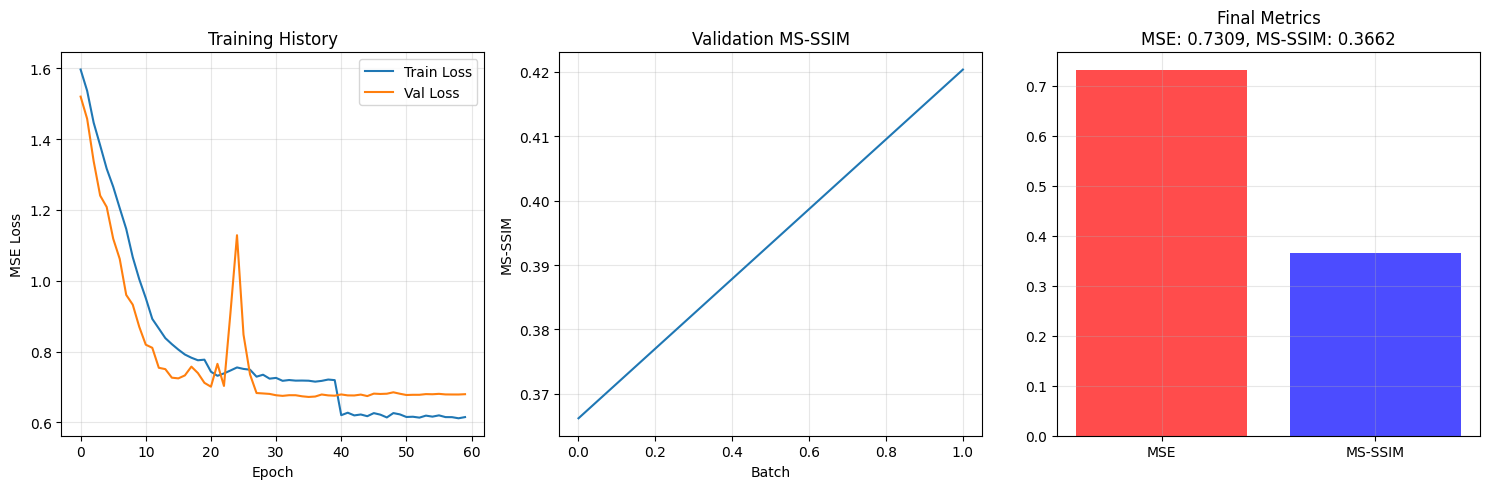


 SAMPLE RECONSTRUCTIONS:


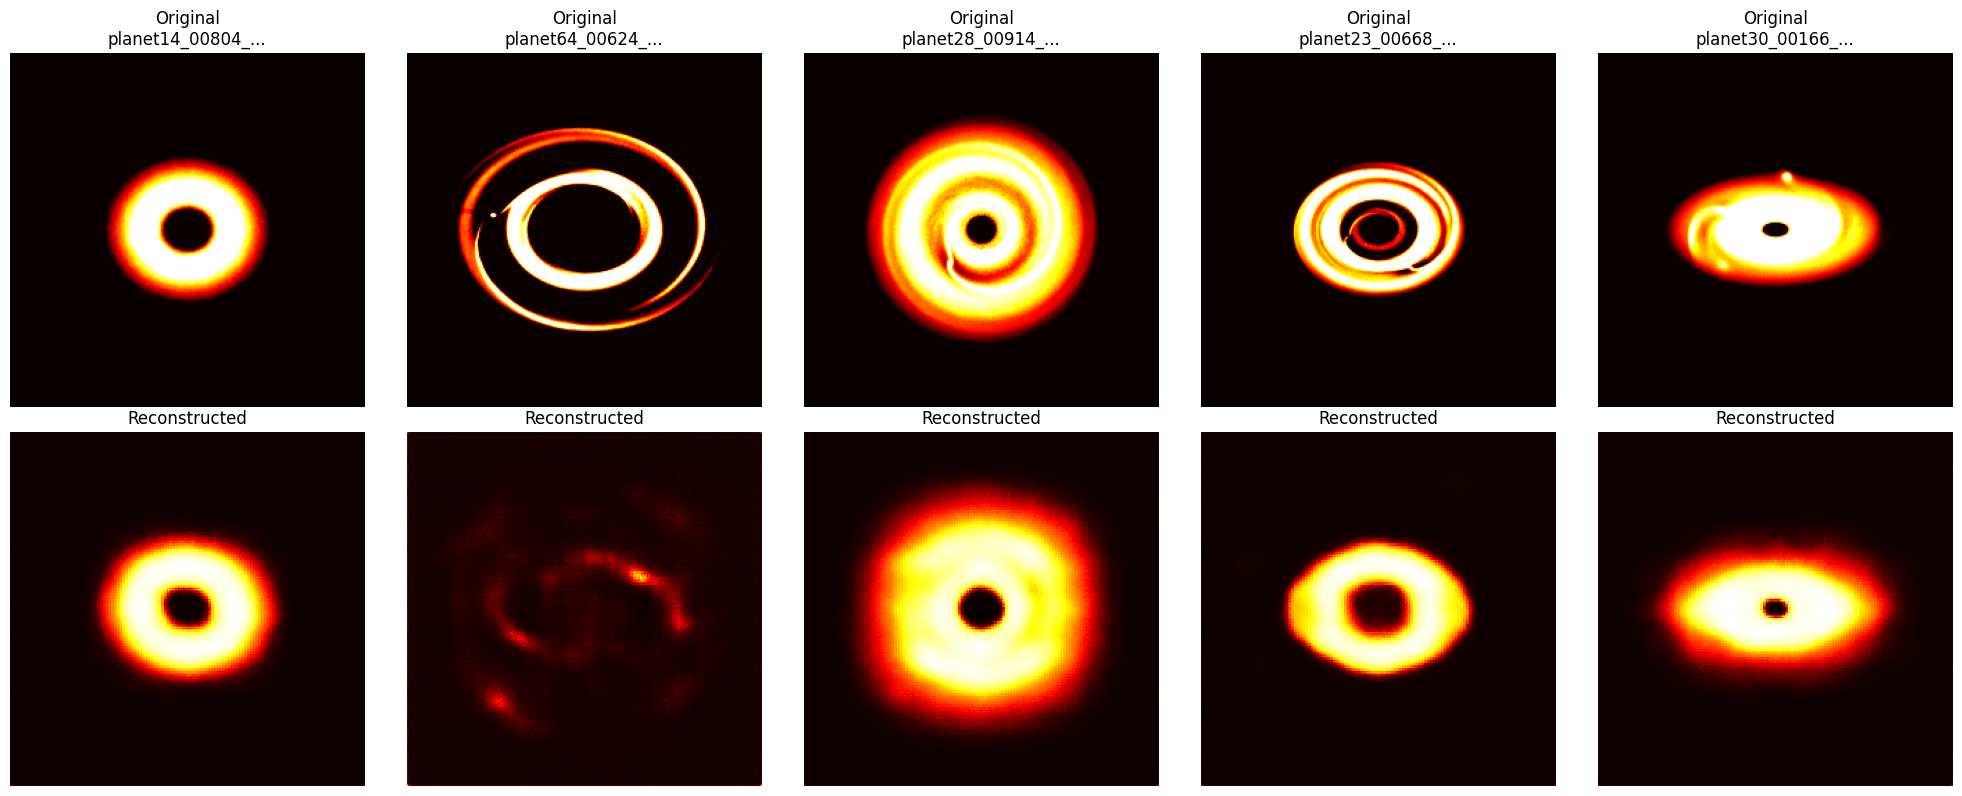

 Final Metrics - MSE: 0.7309, MS-SSIM: 0.3662


In [56]:
# @title Autoencoder Results and Visualization
print("VISUALIZING AUTOENCODER RESULTS...")

# Plot training history
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Training History')
plt.legend()
plt.grid(True, alpha=0.3)

# Calculate MS-SSIM scores for validation
autoencoder.eval()
val_ms_ssim_scores = []
with torch.no_grad():
    for data, _ in val_loader:
        data = data.to(device)
        reconstructed, latent = autoencoder(data)
        ms_ssim_val = ms_ssim(reconstructed, data, data_range=1.0).item()
        val_ms_ssim_scores.append(ms_ssim_val)

plt.subplot(1, 3, 2)
plt.plot(val_ms_ssim_scores)
plt.xlabel('Batch')
plt.ylabel('MS-SSIM')
plt.title('Validation MS-SSIM')
plt.grid(True, alpha=0.3)

# Show sample reconstructions
with torch.no_grad():
    sample_batch, sample_names = next(iter(val_loader))
    sample_batch = sample_batch.to(device)
    reconstructed_batch, latent_batch = autoencoder(sample_batch)

    mse_batch = F.mse_loss(reconstructed_batch, sample_batch).item()
    ms_ssim_batch = ms_ssim(reconstructed_batch, sample_batch, data_range=1.0).item()

plt.subplot(1, 3, 3)
plt.bar(['MSE', 'MS-SSIM'], [mse_batch, ms_ssim_batch], color=['red', 'blue'], alpha=0.7)
plt.title(f'Final Metrics\nMSE: {mse_batch:.4f}, MS-SSIM: {ms_ssim_batch:.4f}')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Show sample reconstructions
print("\n SAMPLE RECONSTRUCTIONS:")
num_samples = min(5, len(sample_batch))
fig, axes = plt.subplots(2, num_samples, figsize=(20, 8))

for i in range(num_samples):
    # Original
    original_img = sample_batch[i].cpu().permute(1, 2, 0).numpy()
    original_img = np.clip(original_img, 0, 1)
    axes[0, i].imshow(original_img[:, :, 0], cmap='hot')
    axes[0, i].set_title(f'Original\n{sample_names[i][:15]}...')
    axes[0, i].axis('off')

    # Reconstructed
    reconstructed_img = reconstructed_batch[i].cpu().permute(1, 2, 0).numpy()
    reconstructed_img = np.clip(reconstructed_img, 0, 1)
    axes[1, i].imshow(reconstructed_img[:, :, 0], cmap='hot')
    axes[1, i].set_title('Reconstructed')
    axes[1, i].axis('off')

plt.tight_layout()
plt.show()

print(f" Final Metrics - MSE: {mse_batch:.4f}, MS-SSIM: {ms_ssim_batch:.4f}")

In [57]:
# @title Save Autoencoder and Demonstrate Latent Space
print("SAVING AUTOENCODER MODEL...")

# Save the trained autoencoder
torch.save({
    'model_state_dict': autoencoder.state_dict(),
    'latent_dim': 512,
    'train_losses': train_losses,
    'val_losses': val_losses
}, 'protoplanetary_autoencoder.pth')

print("Autoencoder saved as 'protoplanetary_autoencoder.pth'")

# Demonstrate latent space access
print("\n DEMONSTRATING LATENT SPACE ACCESS:")

def encode_image(model, image_tensor):
    """Encode an image to latent space"""
    model.eval()
    with torch.no_grad():
        image_tensor = image_tensor.unsqueeze(0).to(device)
        latent_vector = model.encode(image_tensor)
        return latent_vector.cpu().numpy()

def decode_latent(model, latent_vector):
    """Decode a latent vector back to image"""
    model.eval()
    with torch.no_grad():
        latent_tensor = torch.tensor(latent_vector).float().to(device)
        reconstructed = model.decode(latent_tensor)
        return reconstructed.cpu().squeeze(0)

# Testing with a sample image
sample_image, sample_name = val_dataset[0]
latent_vector = encode_image(autoencoder, sample_image)

print(f"Sample image: {sample_name}")
print(f"Latent vector shape: {latent_vector.shape}")
print(f"Latent vector range: [{latent_vector.min():.3f}, {latent_vector.max():.3f}]")
print(f"First 5 latent dimensions: {latent_vector[0, :5]}")

# Testing reconstruction from latent space
reconstructed_from_latent = decode_latent(autoencoder, latent_vector)

print("\n Latent space access demonstrated successfully!")
print("Files to download for submission:")
print("   • protoplanetary_autoencoder.pth")

# Downloading the model
from google.colab import files
files.download('protoplanetary_autoencoder.pth')

SAVING AUTOENCODER MODEL...
Autoencoder saved as 'protoplanetary_autoencoder.pth'

 DEMONSTRATING LATENT SPACE ACCESS:
Sample image: planet14_00804_1250.fits
Latent vector shape: (1, 512)
Latent vector range: [-0.981, 0.938]
First 5 latent dimensions: [-0.25051537 -0.7960761  -0.14204615 -0.1134152   0.7609788 ]

 Latent space access demonstrated successfully!
Files to download for submission:
   • protoplanetary_autoencoder.pth


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>